## Time series

## Citybike's data
Will there be bikes available at a certain point in time?

In [1]:
 # General imports
%matplotlib inline
from preamble import *

We resample the data into three-hour intervals to obtain the main trends for each day:

In [3]:
def load_citibike():
    data_mine = pd.read_csv("citibike.csv")
    data_mine['one'] = 1
    data_mine['starttime'] = pd.to_datetime(data_mine.starttime)
    data_starttime = data_mine.set_index("starttime")
    data_resampled = data_starttime.resample("3h").sum().fillna(0)
    return data_resampled.one
citibike = load_citibike()

The following example shows a visualization of the rental frequencies for the whole month

Text(0, 0.5, 'Rentals')

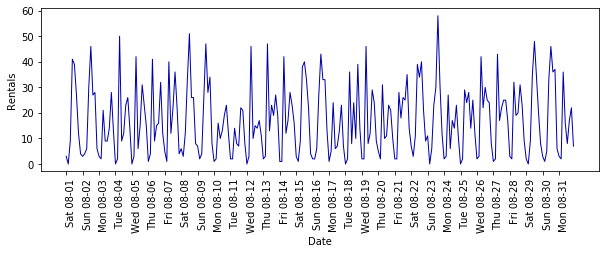

In [4]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

* When evaluating a prediction task on a time series like this, we usually want to learn from the past and predict for the future.
* When doing a split into a training and a test set, we want to use all the data up to a certain date as the training set and all the data past that date as the test set. 
* We will use the first 184 data points (23 days), as our training set, and the remaining 64 data points (8), as our test set.
* Input: date and time, e.g. 2015-08-01 00:00:00
* Output: number of rentals in the following three hours
* Lets first use POSIX representation (number of seconds since January 1970)

In [5]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


In [6]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [7]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


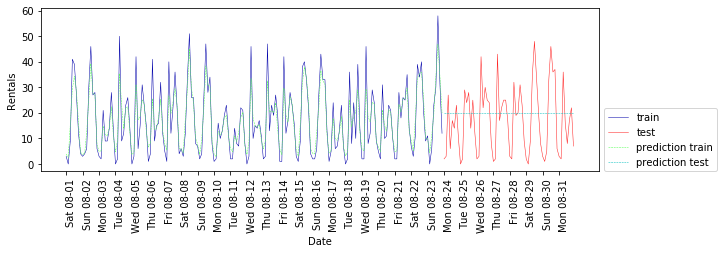

In [8]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

* The problem lies in the combination of our feature and the random forest. 
* The value of the POSIX time feature for the test set is outside of the range of the feature values in the training set
* The points in the test set have timestamps that are later than all the points in the training set. 
* Trees, and therefore random forests, cannot extrapolate to feature ranges outside the training set. 
* The result is that the model simply predicts the target value of the closest point in the training set—which is the last time it observed any data.

* Two factors seem to be very important: the time of day and the day of the week
* We can’t really learn anything from the POSIX time, so we drop that feature. 
* First, let’s use only the hour of the day.

Test-set R^2: 0.60


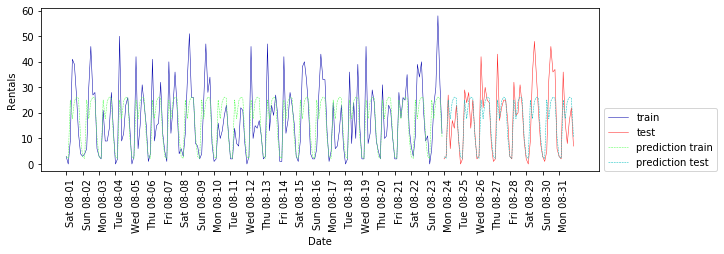

In [9]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

* Now, the predictions have the same pattern for each day of the week
* The R2 is already much better, but the predictions clearly miss the weekly pattern.
* Let’s also add the day of the week

Test-set R^2: 0.84


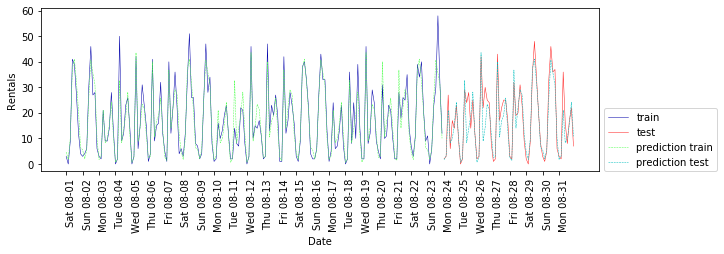

In [10]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

* What this model likely is learning is the mean number of rentals for each combination of weekday and time of day from the first 23 days of August.
* This actually does not require a complex model like a random forest, so let’s try with a simpler model, LinearRegression 

Test-set R^2: 0.13


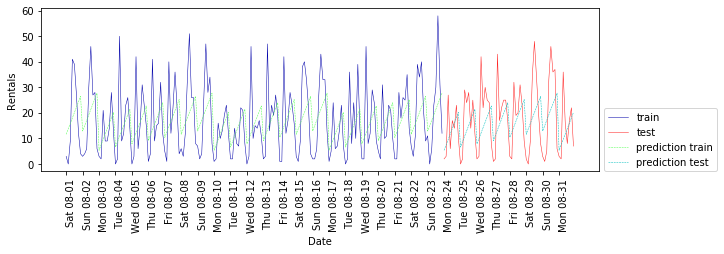

In [11]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

* Problem: We encoded day of week and time of day using integers, which are interpreted as continuous variables. 
* Linear models can only learn a linear function of the time of day—and it learned that later in the day, there are more rentals. 
* We can interpret the integers as categorical variables by transforming them using One HotEncoder

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


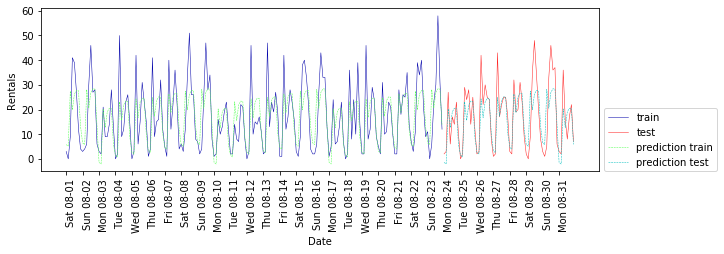

In [14]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot, y, Ridge())

* Using interaction features, we can allow the model to learn one coefficient for each combination of day and time of day 

Test-set R^2: 0.85


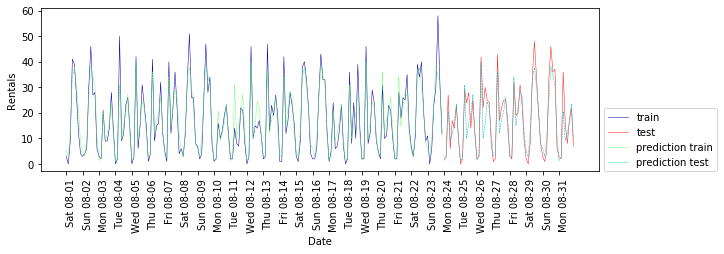

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

* This transformation finally yields a model that performs similarly well to the random forest. 
* A big benefit of this model is that it is very clear what is learned: one coefficient for each day and time. 
* We can simply plot the coefficients learned by the model, something that would not be possible for the random forest.

* First, we create feature names for the hour and day features:

In [16]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

* Then, we name all the interaction features extracted by PolynomialFeatures, using the get_feature_names method, and keep only the features with nonzero coefficients:

In [17]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

* Now we can visualize the coefficients learned by the linear model

Text(0, 0.5, 'Feature magnitude')

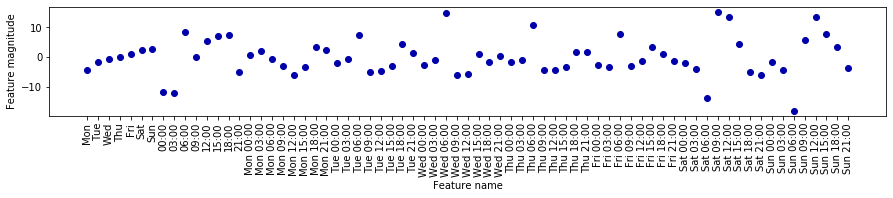

In [18]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")